# MVP and HRP Portfolio Design for Auto Sector Stocks


<a id='1'></a>
## 1. Loading the Data and Python Libraries

<a id='1.1'></a>
### 1.1. Loading the Python Libraries

In [84]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from datetime import date

#Import Model Packages 
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from sklearn.metrics import adjusted_mutual_info_score
from sklearn import cluster, covariance, manifold

#Package for optimization of mean variance optimization
import cvxopt as opt
from cvxopt import blas, solvers


<a id='1.2'></a>
### 1.2. Loading the Data

In [85]:
# load dataset
dataset = read_csv('auto.csv',index_col=0)

In [86]:
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

In [87]:
type(dataset)

pandas.core.frame.DataFrame

<a id='2'></a>
## 2. Exploratory Data Analysis

In [88]:
# shape
dataset.shape

(1481, 10)

In [89]:
# peek at data
set_option('display.width', 100)
dataset.head()

MARUTI         M&M  TATAMOTORS   BAJAJ-AUTO    EICHERMOT   HEROMOTOCO  TIINDIA  \
date                                                                                              
01-01-2016  4638.500000  632.674988  401.899994  2518.000000  1737.084961  2686.050049      NaN   
04-01-2016  4580.649902  621.250000  377.049988  2483.350098  1749.530029  2637.800049      NaN   
05-01-2016  4566.950195  624.599976  374.450012  2502.350098  1715.989990  2616.850098      NaN   
06-01-2016  4480.799805  613.075012  365.899994  2485.500000  1752.505005  2578.199951      NaN   
07-01-2016  4267.899902  598.724976  343.549988  2419.250000  1703.564941  2520.100098      NaN   

             ASHOKLEY  BHARATFORG  BALKRISIND  
date                                           
01-01-2016  88.800003  443.850006  325.075012  
04-01-2016  92.000000  435.450012  326.024994  
05-01-2016  93.099998  428.725006  326.174988  
06-01-2016  92.699997  438.174988  326.674988  
07-01-2016  91.349998  412.325012  326.274994

<a id='3'></a>
## 3. Data Pre-processing

<a id='3.1'></a>
### 3.1. Data Cleaning
We check for the NAs in the rows, either drop them or fill them with the mean of the column.

In [90]:
#Checking for any null values and removing the null values'''
print('Null Values =',dataset.isnull().values.any())
dataset.shape

Null Values = True


(1481, 10)

Getting rid of the columns with more than 30% missing values. 

In [91]:
missing_fractions = dataset.isnull().mean().sort_values(ascending=False)

missing_fractions.head(10)

drop_list = sorted(list(missing_fractions[missing_fractions > 0.4].index))

dataset.drop(labels=drop_list, axis=1, inplace=True)
dataset.shape

(1481, 10)

Given that there are null values drop the rown contianing the null values.

In [92]:
# Fill the missing values with the last value available in the dataset. 
dataset=dataset.fillna(method='ffill')
dataset.head()

MARUTI         M&M  TATAMOTORS   BAJAJ-AUTO    EICHERMOT   HEROMOTOCO  TIINDIA  \
date                                                                                              
01-01-2016  4638.500000  632.674988  401.899994  2518.000000  1737.084961  2686.050049      NaN   
04-01-2016  4580.649902  621.250000  377.049988  2483.350098  1749.530029  2637.800049      NaN   
05-01-2016  4566.950195  624.599976  374.450012  2502.350098  1715.989990  2616.850098      NaN   
06-01-2016  4480.799805  613.075012  365.899994  2485.500000  1752.505005  2578.199951      NaN   
07-01-2016  4267.899902  598.724976  343.549988  2419.250000  1703.564941  2520.100098      NaN   

             ASHOKLEY  BHARATFORG  BALKRISIND  
date                                           
01-01-2016  88.800003  443.850006  325.075012  
04-01-2016  92.000000  435.450012  326.024994  
05-01-2016  93.099998  428.725006  326.174988  
06-01-2016  92.699997  438.174988  326.674988  
07-01-2016  91.349998  412.325012  326.274994

<a id='3.2'></a>
### 3.2. Training and Test Dataset Preparation

For the purpose of clustering, we will be using annual return figures. Let us prepare the dataset for training and testing, by separating 83.35% of the records for training the models and remaining records for testing. These figures have been chosen in such a way that the records of the year 2021 go into the test dataset while other records remain in the training dataset.

In [ ]:
X= dataset.copy('deep')
row= len(X)
train_len = int(row*.8335)

In [94]:
X_train = X.head(train_len)

In [95]:
X_train

MARUTI         M&M  TATAMOTORS   BAJAJ-AUTO    EICHERMOT   HEROMOTOCO  \
date                                                                                     
01-01-2016  4638.500000  632.674988  401.899994  2518.000000  1737.084961  2686.050049   
04-01-2016  4580.649902  621.250000  377.049988  2483.350098  1749.530029  2637.800049   
05-01-2016  4566.950195  624.599976  374.450012  2502.350098  1715.989990  2616.850098   
06-01-2016  4480.799805  613.075012  365.899994  2485.500000  1752.505005  2578.199951   
07-01-2016  4267.899902  598.724976  343.549988  2419.250000  1703.564941  2520.100098   
...                 ...         ...         ...          ...          ...          ...   
24-12-2020  7446.049805  710.900024  175.949997  3374.750000  2436.750000  3073.100098   
28-12-2020  7483.000000  710.950012  186.350006  3414.699951  2451.350098  3082.600098   
29-12-2020  7452.350098  707.049988  183.449997  3431.550049  2460.550049  3074.000000   
30-12-2020  7612.899902  720.700012  184.149994  3448.149902  2517.350098  3101.399902   
31-12-2020  7649.600098  720.599976  183.850006  3444.050049  2530.899902  3110.000000   

               TIINDIA   ASHOKLEY  BHARATFORG   BALKRISIND  
date                                                        
01-01-2016         NaN  88.800003  443.850006   325.075012  
04-01-2016         NaN  92.000000  435.450012   326.024994  
05-01-2016         NaN  93.099998  428.725006   326.174988  
06-01-2016         NaN  92.699997  438.174988   326.674988  
07-01-2016         NaN  91.349998  412.325012   326.274994  
...                ...        ...         ...          ...  
24-12-2020  798.250000  95.250000  526.599976  1555.800049  
28-12-2020  799.549988  95.300003  527.799988  1557.000000  
29-12-2020  799.000000  95.000000  523.450012  1559.550049  
30-12-2020  793.299988  94.800003  517.599976  1615.050049  
31-12-2020  800.849976  95.449997  525.299988  1646.300049  

[1234 rows x 10 columns]

In [96]:
X_test = X.tail(row-train_len)

In [97]:
#Calculate percentage return 
returns = X_train.pct_change().dropna()
returns_test=X_test.pct_change().dropna()

The parameters to clusters are the indices and the variables used in the clustering are the columns. Hence the data is in the right format to be fed to the clustering algorithms.

<a id='4'></a>
## 4. Evaluate the Models

<a id='4.1'></a>
### 4.1. Building Dendrogram for the HRP Model

The first step is to look for clusters of correlated stcoks using the agglomerate hierarchical clustering technique. The hierarchy class
has a dendrogram method which takes the value returned by the linkage method of
the same class.

Linkage does the actual clustering in one line of code, and returns a list of the clusters joined in the format: Z=[stock_1, stock_2, distance, sample_count]

#### Correlation Computation

In [98]:
def correlDist(corr):
    # A distance matrix based on correlation, where 0<=d[i,j]<=1
    # This is a proper distance metric
    dist = ((1 - corr) / 2.)**.5  # distance matrix
    return dist

In [99]:
#Calulate linkage
dist = correlDist(returns.corr())
link = linkage(dist, 'ward')
link[0]

array([3.        , 5.        , 0.59042387, 2.        ])

Computation of linkages is followed by the visualization of the clusters through a dendrogram, which displays a cluster tree.
The leaves are the individual stocks and the root represents the final single cluster. The “distance” between each cluster is shown along the y-axis, and thus the longer the branches indicate less correlated clusters of stcoks.

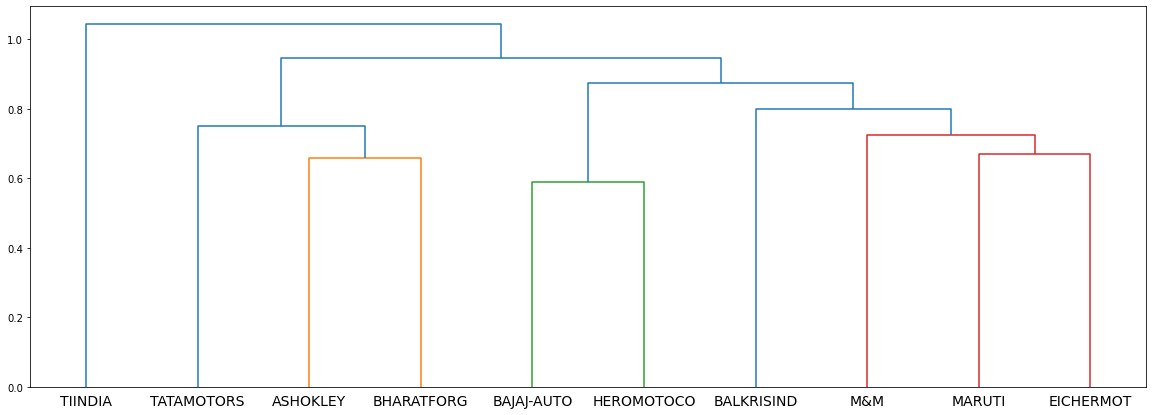

In [100]:
#Plot Dendogram
plt.figure(figsize=(20, 7))
#plt.title("Dendrograms")
dendrogram(link,labels = X.columns, leaf_font_size=14)
plt.show()

<a id='4.2'></a>
### 4.2 Steps involved in the HRP Model Design 

#### Quasi-Diagonalization and Weights Computation for HRP


Quasi-diagonalization is a matrix seriation process used in hierarchical clustering. The process involves reorganizing the covariance matrix of returns in such a way that stocks with similar returns are placed together. This matrix diagonalization allows us to distribute weights optimally following an inverse-variance allocation. For more details refer to Chapter 4 of the book.

In [101]:
def getQuasiDiag(link):
    # Sort clustered items by distance
    link = link.astype(int)
    sortIx = pd.Series([link[-1, 0], link[-1, 1]])
    numItems = link[-1, 3]  # number of original items
    while sortIx.max() >= numItems:
        sortIx.index = range(0, sortIx.shape[0] * 2, 2)  # make space
        df0 = sortIx[sortIx >= numItems]  # find clusters
        i = df0.index
        j = df0.values - numItems
        sortIx[i] = link[j, 0]  # item 1
        df0 = pd.Series(link[j, 1], index=i + 1)
        sortIx = sortIx.append(df0)  # item 2
        sortIx = sortIx.sort_index()  # re-sort
        sortIx.index = range(sortIx.shape[0])  # re-index
    return sortIx.tolist()

#### Recursive Bisection

This step distributes the weights through recursive bisection based on the cluster covariance.

In [102]:
def getClusterVar(cov,cItems):
    # Compute variance per cluster
    cov_=cov.loc[cItems,cItems] # matrix slice
    w_=getIVP(cov_).reshape(-1,1)
    cVar=np.dot(np.dot(w_.T,cov_),w_)[0,0]
    return cVar



def getRecBipart(cov, sortIx):
    # Compute HRP alloc
    w = pd.Series(1, index=sortIx)
    cItems = [sortIx]  # initialize all items in one cluster
    while len(cItems) > 0:
        cItems = [i[j:k] for i in cItems for j, k in ((0, len(i) // 2), (len(i) // 2, len(i))) if len(i) > 1]  # bi-section
        for i in range(0, len(cItems), 2):  # parse in pairs
            cItems0 = cItems[i]  # cluster 1
            cItems1 = cItems[i + 1]  # cluster 2
            cVar0 = getClusterVar(cov, cItems0)
            cVar1 = getClusterVar(cov, cItems1)
            alpha = 1 - cVar0 / (cVar0 + cVar1)
            w[cItems0] *= alpha  # weight 1
            w[cItems1] *= 1 - alpha  # weight 2
    return w

#### Comparison of HRP with MVP

So, in this step, python functions are defined for comparing the following two portfolio design approaches.

    1. MVP - Markowitz’s Minimum-Variance Portfolio
    2. HRP - Hierarchial Risk Parity

In [103]:
def getMVP(cov):

    cov = cov.T.values
    n = len(cov)
    N = 100
    mus = [10 ** (5.0 * t / N - 1.0) for t in range(N)]

    # Convert to cvxopt matrices
    S = opt.matrix(cov)
    #pbar = opt.matrix(np.mean(returns, axis=1))
    pbar = opt.matrix(np.ones(cov.shape[0]))

    # Create constraint matrices
    G = -opt.matrix(np.eye(n))  # negative n x n identity matrix
    h = opt.matrix(0.0, (n, 1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)
    
    
    # Calculate efficient frontier weights using quadratic programming
    solvers.options['show_progress'] = False
    portfolios = [solvers.qp(mu * S, -pbar, G, h, A, b)['x']
                  for mu in mus]
    ## CALCULATE RISKS AND RETURNS FOR FRONTIER    
    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S * x)) for x in portfolios]
    ## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE
    m1 = np.polyfit(returns, risks, 2)
    x1 = np.sqrt(m1[2] / m1[0])
    # CALCULATE THE OPTIMAL PORTFOLIO    
    wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']

    return list(wt)

def getIVP(cov, **kargs):
    # Compute the inverse-variance portfolio
    ivp = 1. / np.diag(cov)
    ivp /= ivp.sum()
    return ivp

def getHRP(cov, corr):
    # Construct a hierarchical portfolio
    dist = correlDist(corr)
    link = sch.linkage(dist, 'single')
    #plt.figure(figsize=(20, 10))
    #dn = sch.dendrogram(link, labels=cov.index.values)
    #plt.show()
    sortIx = getQuasiDiag(link)
    sortIx = corr.index[sortIx].tolist()
    hrp = getRecBipart(cov, sortIx)
    return hrp.sort_index()

#### Computation of the Weight Allocation for the Portfolios

In [104]:
def get_all_portfolios(returns):
    
    cov, corr = returns.cov(), returns.corr()
    hrp = getHRP(cov, corr)
    mvp = getMVP(cov)
    mvp = pd.Series(mvp, index=cov.index)
    portfolios = pd.DataFrame([mvp, hrp], index=['MVP', 'HRP']).T
    #portfolios = pd.DataFrame([ivp, hrp], index=['IVP', 'HRP']).T
    return portfolios

In [105]:
portfolios = get_all_portfolios(returns)
print(portfolios)

                 MVP       HRP
MARUTI      0.020786  0.127167
M&M         0.071410  0.125107
TATAMOTORS  0.005043  0.062498
BAJAJ-AUTO  0.376478  0.112355
EICHERMOT   0.070831  0.117391
HEROMOTOCO  0.074762  0.080464
TIINDIA     0.209510  0.128163
ASHOKLEY    0.006801  0.042289
BHARATFORG  0.012505  0.062719
BALKRISIND  0.151874  0.141847


Text(0.5, 1.0, 'HRP')

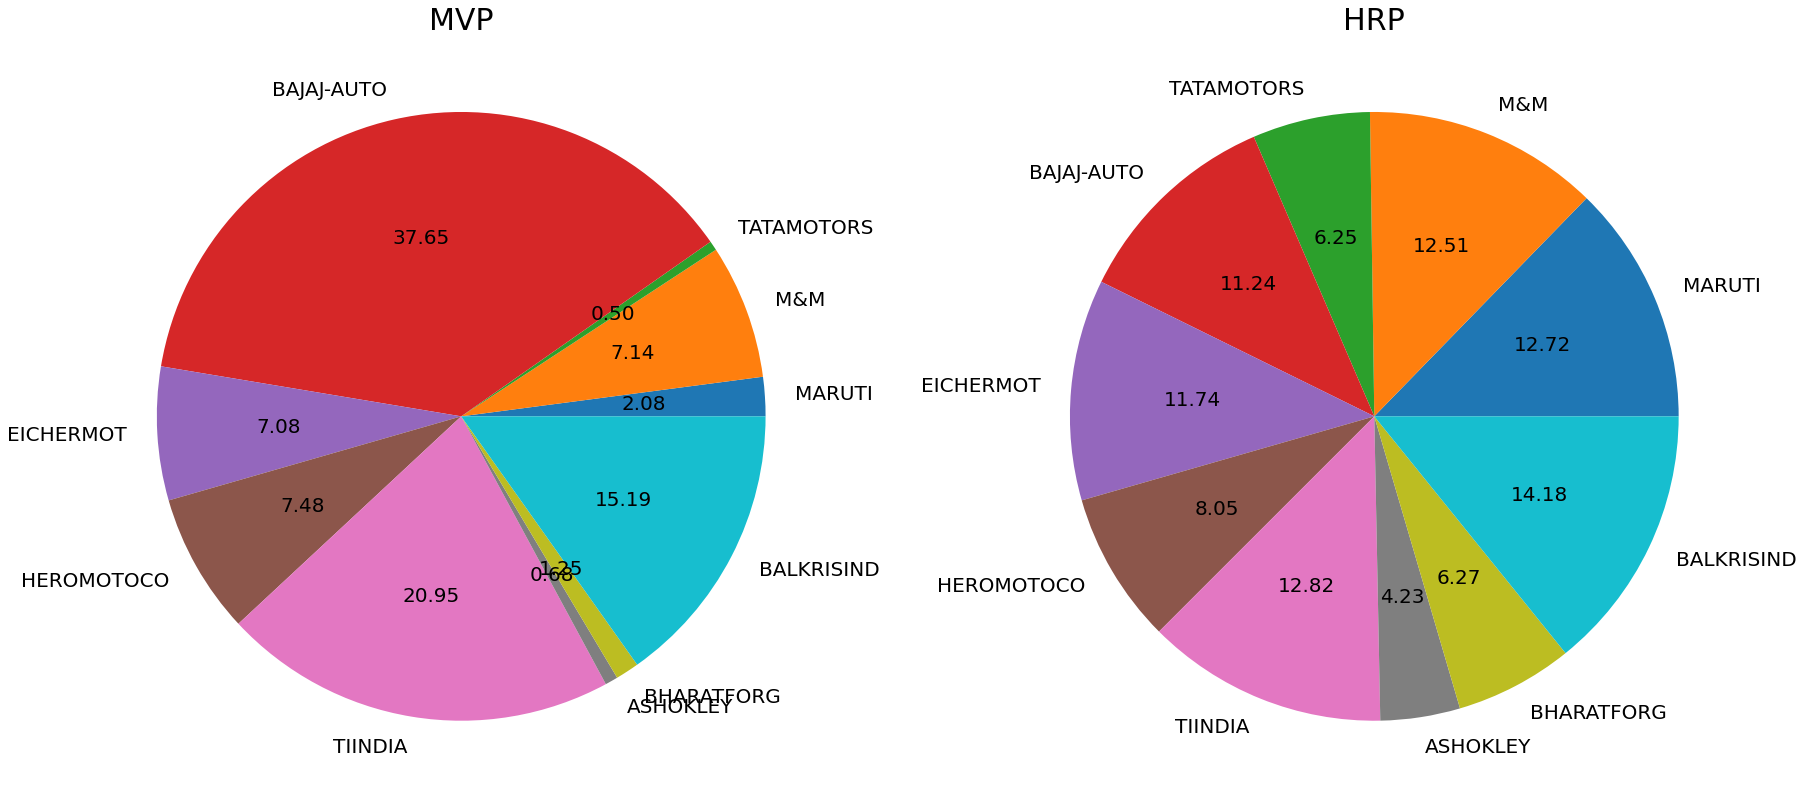

In [106]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(30,20))
ax1.pie(portfolios.iloc[:,0], labels= portfolios.index, autopct='%.2f', textprops={'fontsize': 20});
ax1.set_title('MVP',fontsize = 30)
ax2.pie(portfolios.iloc[:,1], labels=portfolios.index, autopct='%.2f', textprops={'fontsize': 20});
ax2.set_title('HRP',fontsize = 30)
#portfolios.plot.pie(subplots=True, figsize=(20, 10),legend = False);

In [107]:
# MVP - Markowitz’s Minimum-Variance Portfolio Weights
portfolios.iloc[:,0]

MARUTI        0.020786
M&M           0.071410
TATAMOTORS    0.005043
BAJAJ-AUTO    0.376478
EICHERMOT     0.070831
HEROMOTOCO    0.074762
TIINDIA       0.209510
ASHOKLEY      0.006801
BHARATFORG    0.012505
BALKRISIND    0.151874
Name: MVP, dtype: float64

In [108]:
# HRP - Hierarchial Risk Parity Portfolio Weights
portfolios.iloc[:,1]

MARUTI        0.127167
M&M           0.125107
TATAMOTORS    0.062498
BAJAJ-AUTO    0.112355
EICHERMOT     0.117391
HEROMOTOCO    0.080464
TIINDIA       0.128163
ASHOKLEY      0.042289
BHARATFORG    0.062719
BALKRISIND    0.141847
Name: HRP, dtype: float64

<a id='5'></a>
## 5. Performance Evaluation of the Portfolios 

### 5.1 Cumulative Returns - Training and Test Data 

In [109]:
Insample_Result=pd.DataFrame(np.dot(returns,np.array(portfolios)), \
                             columns=['MVP', 'HRP'], index = returns.index)
OutOfSample_Result=pd.DataFrame(np.dot(returns_test,np.array(portfolios)), \
                                columns=['MVP', 'HRP'], index = returns_test.index)

<AxesSubplot:xlabel='date', ylabel='Return'>

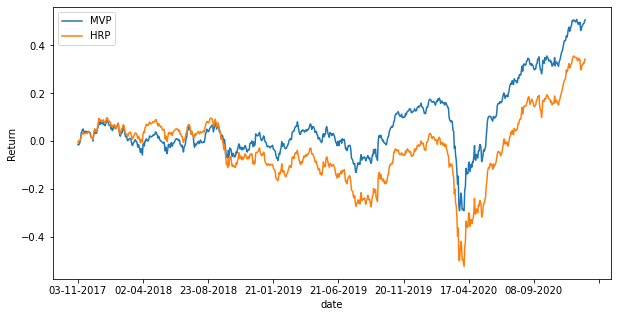

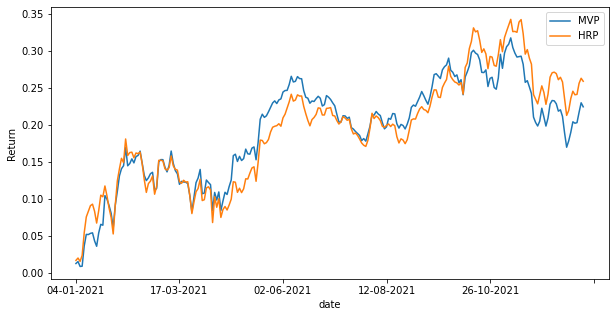

In [116]:
Insample_Result.cumsum().plot(figsize=(10, 5), ylabel = "Return")
OutOfSample_Result.cumsum().plot(figsize=(10, 5), ylabel = "Return")

In [111]:
ret_insample=Insample_Result.mean() * 252
ret_insample

MVP    0.163785
HRP    0.110886
dtype: float64

In [117]:
ret_out_of_sample = OutOfSample_Result.mean() * 252
ret_out_of_sample

MVP    0.229982
HRP    0.265352
dtype: float64

###  5.2 Sharpe Ratio and Annual Volatility - Training and Test Data

In [118]:
#In_sample Results
stddev = Insample_Result.std() * np.sqrt(252)
sharp_ratio = (Insample_Result.mean()*np.sqrt(252))/(Insample_Result).std()
Results = pd.DataFrame(dict(stdev=stddev, sharp_ratio = sharp_ratio))
Results

stdev  sharp_ratio
MVP  0.235413     0.695733
HRP  0.254919     0.434987

In [114]:
#Outof_sample Results
stddev_oos = OutOfSample_Result.std() * np.sqrt(252)
sharp_ratio_oos = (OutOfSample_Result.mean()*np.sqrt(252))/(OutOfSample_Result).std()
Results_oos = pd.DataFrame(dict(stdev_oos=stddev_oos, sharp_ratio_oos = sharp_ratio_oos))
Results_oos

stdev_oos  sharp_ratio_oos
MVP    0.19094         1.204476
HRP    0.20289         1.307864